# San Francisco Crime Dataset Use Case. Module 5. MAABD

Created on Sat Dec  2 19:05:14 2017 

#### @author: Jose-Manuel García-Nieto

In [1]:
#Importing required packages
import re
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import HTML
import json

import sys
sys.path.insert(0,'..')
import folium
print (folium.__file__)
print (folium.__version__)
from matplotlib.colors import Normalize, rgb2hex

import pymongo
from pymongo import MongoClient, GEO2D

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/folium/__init__.py
0.10.1


#### First data exploration

In [2]:
# Data import from csv
total_crime=pd.read_csv('/home/master/Descargas/Map_of_Police_Department_Incidents.csv')
print(total_crime.shape)
d_crime=total_crime.head(600000)

(2133457, 12)


In [3]:
# Data cleaning. Transform Data from string to date type and delta date
date=pd.to_datetime(d_crime['Date'])
print(date.min())
print(date.max())

2003-01-01 00:00:00
2017-04-19 00:00:00


In [4]:
# Create a new colum "days" with timedelta format
t_delta=(date-date.min()).astype('timedelta64[D]')
d_crime['days']=t_delta
d_crime.head(1)

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


IncidntNum      Category       Descript DayOfWeek                    Date  \
0   150060275  NON-CRIMINAL  LOST PROPERTY    Monday  01/19/2015 12:00:00 AM   

    Time PdDistrict Resolution                Address           X          Y  \
0  14:00    MISSION       NONE  18TH ST / VALENCIA ST -122.421582  37.761701   

                               Location    days  
0  (37.7617007179518, -122.42158168137)  4401.0

In [5]:
# Plotting bargraph
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='b')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

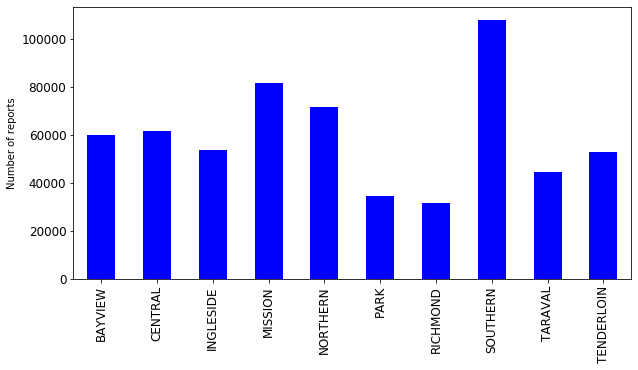

In [6]:
plotdat(d_crime,'PdDistrict')

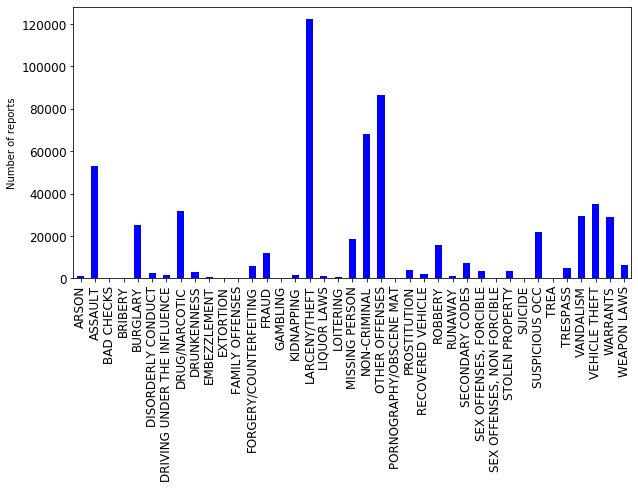

In [7]:
plotdat(d_crime,'Category')

In [8]:
l=d_crime.groupby('Descript').size()
l.sort_values()
print(l.shape)

(867,)


In [9]:
# Heatmap and hierarchical clustering
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [10]:
t=types_districts(d_crime,98)

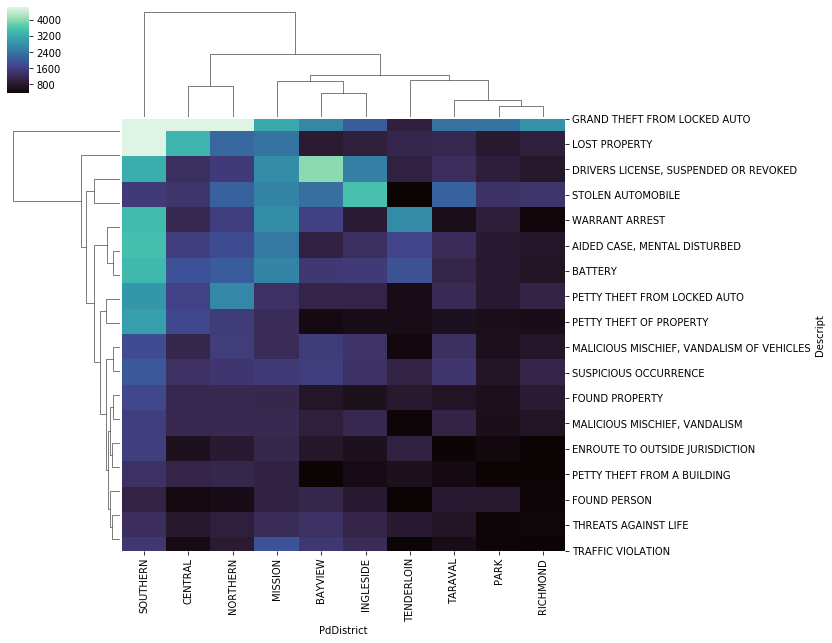

In [11]:
sns.clustermap(t,cmap="mako", robust=True) 

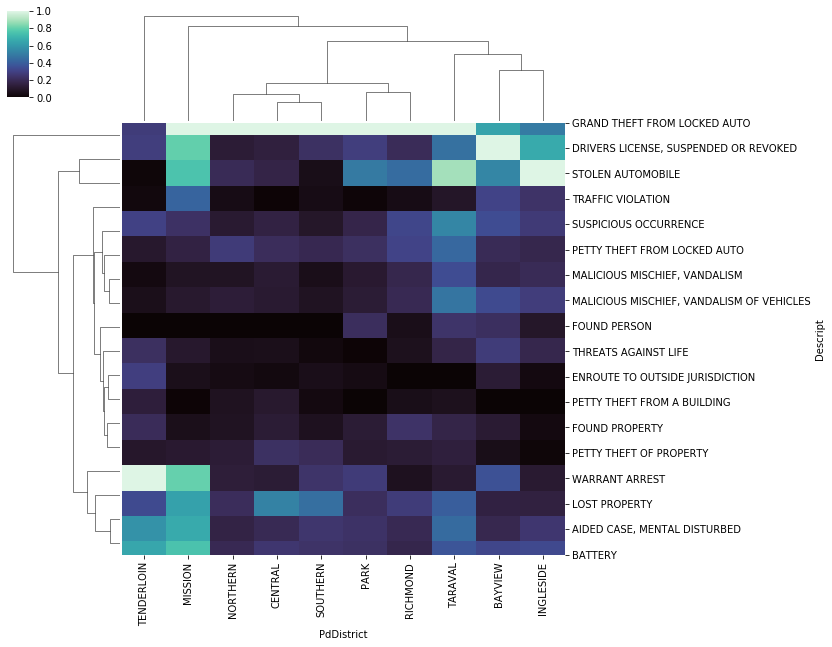

In [12]:
# It is required to scale dimensions
# Standardize the data within the columns (scale=1)
# Sometimes, a few values in your input have extreme values. 
# In a heatmap, this has as an effect to make every other cell the same color, what is not desired. 
# The clustermap function allows you to avoid that with the ‘robust‘ argument. Here is an example with (left) and without (right) this option.

sns.clustermap(t,standard_scale=1,cmap="mako", robust=True)

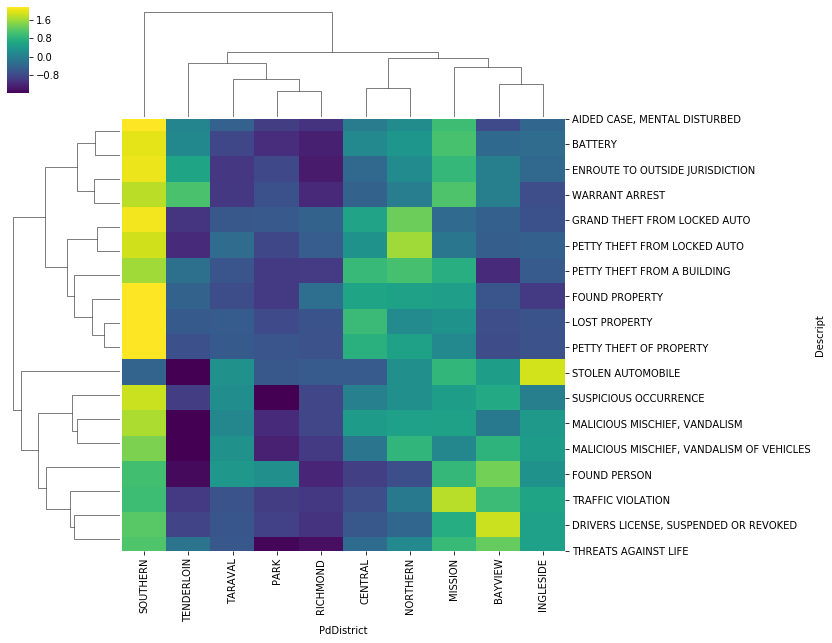

In [13]:
# Normalize the data within the rows s_score=0
sns.clustermap(t,z_score=0,cmap="viridis", robust=True)

#### Let's drill down onto one

###### Mongo Database connection and store data______________________________________________________________________________

In [14]:
print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.test
collection = db.crimesf

Mongo version 3.9.0


In [15]:
#Clean collection 
collection.drop()

In [16]:
#Import data into the database. First, transform to JSON records
records = json.loads(d_crime.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)

In [17]:
#Check if we can access the data from the MongoDB.
cursor = collection.find().sort('Category',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e259608a22d6df14545e030'), 'IncidntNum': 140009459, 'Category': 'ARSON', 'Descript': 'ARSON', 'DayOfWeek': 'Saturday', 'Date': '01/04/2014 12:00:00 AM', 'Time': '03:52', 'PdDistrict': 'NORTHERN', 'Resolution': 'ARREST, BOOKED', 'Address': 'SACRAMENTO ST / POLK ST', 'X': -122.4208746324, 'Y': 37.7914943052, 'Location': '(37.7914943051906, -122.420874632415)', 'days': 4021.0}
{'_id': ObjectId('5e259608a22d6df14545e0f2'), 'IncidntNum': 150100081, 'Category': 'ARSON', 'Descript': 'ARSON OF AN INHABITED DWELLING', 'DayOfWeek': 'Monday', 'Date': '02/02/2015 12:00:00 AM', 'Time': '10:05', 'PdDistrict': 'MISSION', 'Resolution': 'ARREST, BOOKED', 'Address': '500 Block of VALENCIA ST', 'X': -122.4218764885, 'Y': 37.7640888945, 'Location': '(37.7640888944532, -122.421876488492)', 'days': 4415.0}
{'_id': ObjectId('5e259608a22d6df14545e131'), 'IncidntNum': 150100677, 'Category': 'ARSON', 'Descript': 'ARSON OF A VEHICLE', 'DayOfWeek': 'Monday', 'Date': '02/02/2015 12:00:00 AM', 'T

In [18]:
# stablish a pipeline to select all rows matching attribute "Category" = "DRUG/NARCOTIC"
pipeline = [
        {"$match": {"Category":"DRUG/NARCOTIC"}},
]

In [19]:
#Query the collection with the pipeline filter. 
aggResult = collection.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))
df2.head()

_id  IncidntNum       Category  \
0  5e259608a22d6df14545e01c   150098345  DRUG/NARCOTIC   
1  5e259608a22d6df14545e01d   150098345  DRUG/NARCOTIC   
2  5e259608a22d6df14545e031   150098458  DRUG/NARCOTIC   
3  5e259608a22d6df14545e03b   150098527  DRUG/NARCOTIC   
4  5e259608a22d6df14545e074   150098997  DRUG/NARCOTIC   

                                   Descript DayOfWeek                    Date  \
0            POSSESSION OF METH-AMPHETAMINE    Sunday  02/01/2015 12:00:00 AM   
1     POSSESSION OF NARCOTICS PARAPHERNALIA    Sunday  02/01/2015 12:00:00 AM   
2  POSSESSION OF BASE/ROCK COCAINE FOR SALE    Sunday  02/01/2015 12:00:00 AM   
3            POSSESSION OF METH-AMPHETAMINE    Sunday  02/01/2015 12:00:00 AM   
4                   POSSESSION OF MARIJUANA    Sunday  02/01/2015 12:00:00 AM   

    Time PdDistrict      Resolution                    Address           X  \
0  14:00    MISSION  ARREST, BOOKED  1700 Block of HARRISON ST -122.413354   
1  14:00    MISSION  ARREST, BOOKED  1700 Block of HARRISON ST -122.413354   
2  16:56    MISSION  ARREST, BOOKED   2000 Block of MISSION ST -122.419520   
3  17:02    MISSION  ARREST, BOOKED       MISSION ST / 15TH ST -122.419828   
4  20:35   SOUTHERN            NONE     700 Block of MARKET ST -122.403919   

           Y                               Location    days  
0  37.769075  (37.7690748003847, -122.413354187018)  4414.0  
1  37.769075  (37.7690748003847, -122.413354187018)  4414.0  
2  37.764229   (37.764228935718, -122.419520367886)  4414.0  
3  37.766674  (37.7666737551835, -122.419827929961)  4414.0  
4  37.787116  (37.7871160984672, -122.403919148357)  4414.0

In [20]:
#How many rows the collection has?
collection.find({"Category":"DRUG/NARCOTIC"}).count()

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


31606

In [21]:
# Let's have a look on incidents' descriptions
c=df2['Descript'].value_counts()
c.sort_values(ascending=False)
c.head(10)

POSSESSION OF NARCOTICS PARAPHERNALIA       6140
POSSESSION OF BASE/ROCK COCAINE             3516
POSSESSION OF MARIJUANA                     3463
POSSESSION OF METH-AMPHETAMINE              2631
SALE OF BASE/ROCK COCAINE                   2245
POSSESSION OF BASE/ROCK COCAINE FOR SALE    1946
POSSESSION OF MARIJUANA FOR SALES           1620
POSSESSION OF HEROIN                        1236
POSSESSION OF CONTROLLED SUBSTANCE          1213
POSSESSION OF COCAINE                        917
Name: Descript, dtype: int64

In [22]:
# Organize incidents' descriptions versus Districts where they were detected
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [23]:
# Filter outliers up to 75 percentile
t=types_districts(df2,75)

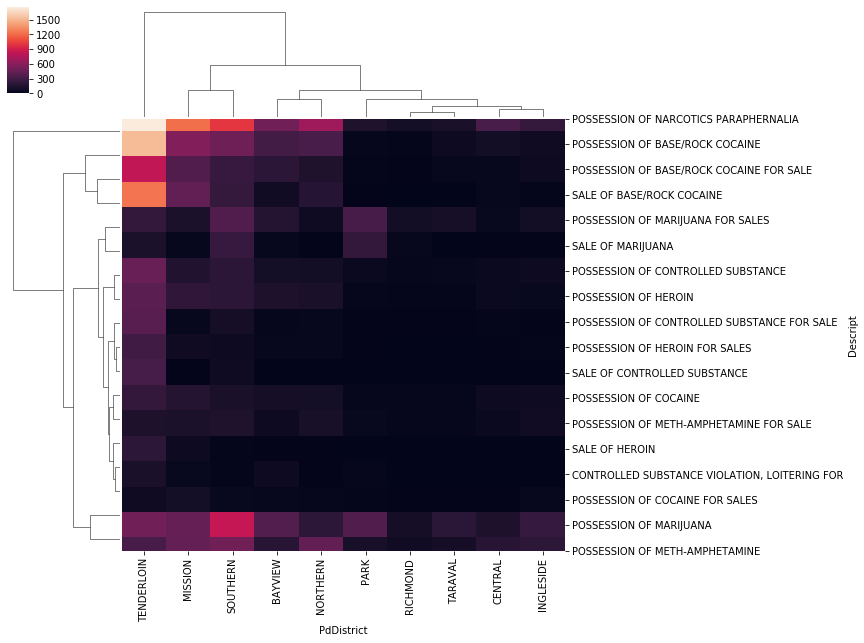

In [24]:
# Inspect data by means of clustermaps
sns.clustermap(t)

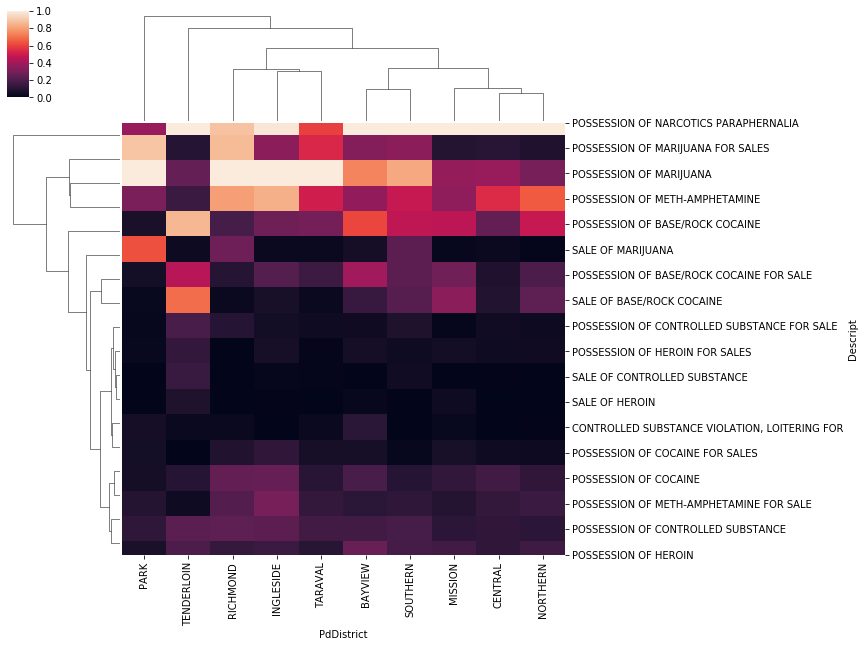

In [25]:
sns.clustermap(t,standard_scale=1)

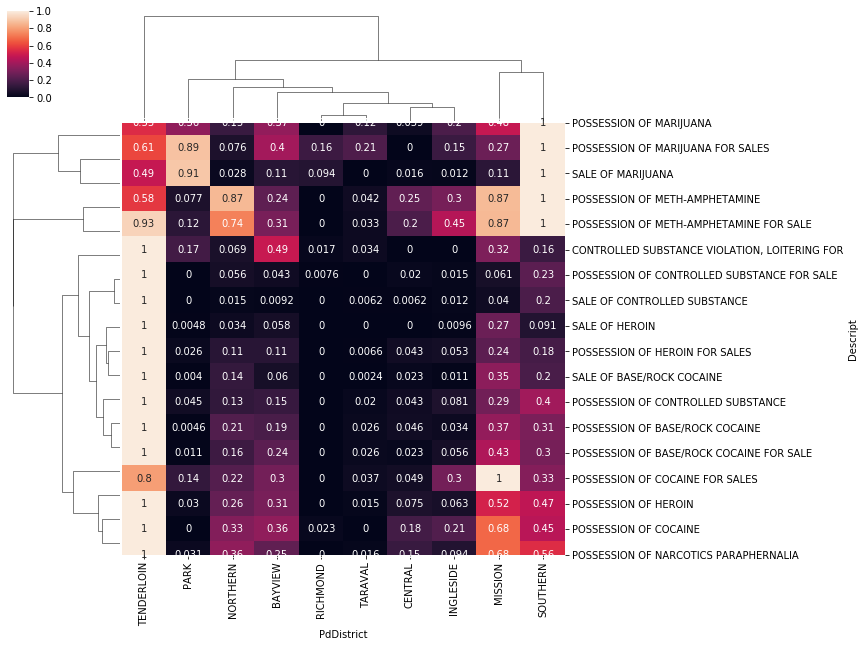

In [26]:
sns.clustermap(t,standard_scale=0, annot=True)

#### Time Series Analysis

In [27]:
# Bin crime by 30 day window. That is, obtain new colum with corresponding months 
df2['Month']=np.floor(df2['days']/30) # Approximate month (30 day window)

In [28]:
# Default
district='All'

In [29]:
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').Descript.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
  
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    
    return t

In [30]:
t_all=timeseries(df2,10)

In [31]:
#Find inciden's descriptions related to word patter "BARBITUATES"
pat = re.compile(r'BARBITUATES', re.I)

In [32]:
pipeline = [
        {"$match": {"Category":"DRUG/NARCOTIC" , 'Descript': {'$regex': pat}}},
]

In [33]:
aggResult = collection.aggregate(pipeline)
df3 = pd.DataFrame(list(aggResult))
df3.head()

_id  IncidntNum       Category  \
0  5e259608a22d6df14546766c   140546718  DRUG/NARCOTIC   
1  5e25960aa22d6df1454906b9   150579204  DRUG/NARCOTIC   
2  5e25960aa22d6df14549defe    61018636  DRUG/NARCOTIC   
3  5e25960aa22d6df1454a192b    80400856  DRUG/NARCOTIC   
4  5e25960aa22d6df1454aecbf    90083793  DRUG/NARCOTIC   

                              Descript DayOfWeek                    Date  \
0                  SALE OF BARBITUATES   Tuesday  07/01/2014 12:00:00 AM   
1                  SALE OF BARBITUATES    Friday  07/03/2015 12:00:00 AM   
2  POSSESSION OF BARBITUATES FOR SALES  Saturday  09/23/2006 12:00:00 AM   
3  POSSESSION OF BARBITUATES FOR SALES  Thursday  04/17/2008 12:00:00 AM   
4   ENCOURAGE MINOR TO USE BARBITUATES    Friday  01/23/2009 12:00:00 AM   

    Time  PdDistrict      Resolution                          Address  \
0  18:54    NORTHERN  ARREST, BOOKED               POLK ST / CEDAR ST   
1  12:05  TENDERLOIN  ARREST, BOOKED  LEAVENWORTH ST / GOLDEN GATE AV   
2  16:08    NORTHERN  ARREST, BOOKED          OFARRELL ST / LARKIN ST   
3  10:48     TARAVAL  ARREST, BOOKED         900 Block of RANDOLPH ST   
4  14:15     BAYVIEW  ARREST, BOOKED         1600 Block of LASALLE AV   

            X          Y                               Location    days  
0 -122.419835  37.786358  (37.7863580362743, -122.419834938618)  4199.0  
1 -122.413870  37.781862  (37.7818621883021, -122.413869632554)  4566.0  
2 -122.417904  37.785167  (37.7851670875517, -122.417903977564)  1361.0  
3 -122.471556  37.714949   (37.714949488487, -122.471555654261)  1933.0  
4 -122.390166  37.737408   (37.737407942936, -122.390166019588)  2214.0

In [34]:
barbituates = df3.groupby('Descript').size()
s = pd.Series(barbituates)

In [35]:
print(s)

Descript
ENCOURAGE MINOR TO USE BARBITUATES     2
POSSESSION OF BARBITUATES              1
POSSESSION OF BARBITUATES FOR SALES    2
SALE OF BARBITUATES                    2
dtype: int64


In [36]:
s = s[s != 1]

In [37]:
barituate_features = list(s.index)

In [38]:
print(barituate_features)

['ENCOURAGE MINOR TO USE BARBITUATES', 'POSSESSION OF BARBITUATES FOR SALES', 'SALE OF BARBITUATES']


In [39]:
#Let's generate a function to constructu subsets of descriptions according to patterns: COCAINE, MARIJUANA, METHADONE, etc.
def descriptionsAccordingToPattern(pattern):
    pat = re.compile(pattern, re.I)
   
    pipeline = [
            {"$match": {"Category":"DRUG/NARCOTIC" , 'Descript': {'$regex': pat}}},
    ]
    
    aggResult = collection.aggregate(pipeline)
    df3 = pd.DataFrame(list(aggResult))
    drug = df3.groupby('Descript').size()
    s = pd.Series(drug)
    s = s[s != 1] # filter those descriptions with value less equal 1
    features = list(s.index)
    
    return features

In [40]:
# Filter by pattern 'COCAINE'
coke_features = descriptionsAccordingToPattern('COCAINE')

In [41]:
print(coke_features)

['ENCOURAGING MINOR TO USE COCAINE', 'POSSESSION OF BASE/ROCK COCAINE', 'POSSESSION OF BASE/ROCK COCAINE FOR SALE', 'POSSESSION OF COCAINE', 'POSSESSION OF COCAINE FOR SALES', 'SALE OF BASE/ROCK COCAINE', 'SALE OF COCAINE', 'SALES COCAINE BASE/SCHOOLYARD TRAFFICKING ACT VIO', 'TRANSPORTATION OF COCAINE']


In [42]:
weed_features = descriptionsAccordingToPattern('MARIJUANA')
metadone_features = descriptionsAccordingToPattern('METHADONE')
hallu_features = descriptionsAccordingToPattern('HALLUCINOGENIC')
opium_features = descriptionsAccordingToPattern('OPIUM')
opiates_features = descriptionsAccordingToPattern('OPIATES')
meth_features = descriptionsAccordingToPattern('AMPHETAMINE')
heroin_features = descriptionsAccordingToPattern('HEROIN')
crack_features = descriptionsAccordingToPattern('BASE/ROCK')

In [43]:
# Lets use real dates for plotting
days_from_start=pd.Series(t_all.index*30).astype('timedelta64[D]')
dates_for_plot=date.min()+days_from_start
time_labels=dates_for_plot.map(lambda x: str(x.year)+'-'+str(x.month))

In [44]:
# Analytics per drug tipology according to descriptions
def drug_analysis(t,district,plot):
    t['BARBITUATES']=t[barituate_features].sum(axis=1)
    t['HEROIN']=t[heroin_features].sum(axis=1)
    t['HALLUCINOGENIC']=t[hallu_features].sum(axis=1)
    t['AMPHETAMINE']=t[meth_features].sum(axis=1)
    t['WEED']=t[weed_features].sum(axis=1)
    t['COKE']=t[coke_features].sum(axis=1)
    t['METHADONE']=t[metadone_features].sum(axis=1)
    t['CRACK']=t[crack_features].sum(axis=1)
    t['OPIUM']=t[opium_features].sum(axis=1)
    t['OPIATES']=t[opiates_features].sum(axis=1)

    drugs=t[['BARBITUATES','HEROIN','HALLUCINOGENIC','AMPHETAMINE','WEED','COKE','METHADONE','CRACK','OPIUM','OPIATES']]
    if plot:
        drugs.index=[int(i) for i in drugs.index]
        colors = plt.cm.jet(np.linspace(0, 1, drugs.shape[1]))
        drugs.plot(kind='bar', stacked=True, figsize=(20,5), color=colors, width=1, title=district,fontsize=6)
    return drugs

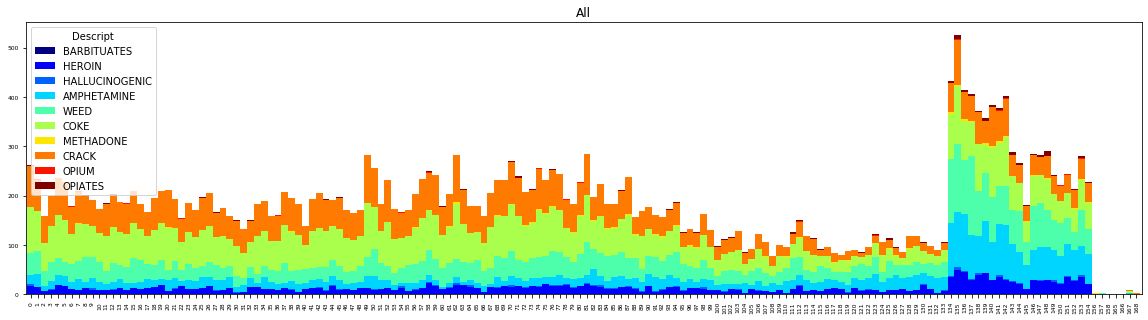

In [45]:
drug_df_all=drug_analysis(t_all,district,True)

In [46]:
def drug_analysis_rescale(t,district,plot):
    t['BARBITUATES']=t[barituate_features].sum(axis=1)
    t['HEROIN']=t[heroin_features].sum(axis=1)
    t['HALLUCINOGENIC']=t[hallu_features].sum(axis=1)
    t['AMPHETAMINE']=t[meth_features].sum(axis=1)
    t['WEED']=t[weed_features].sum(axis=1)
    t['COKE']=t[coke_features].sum(axis=1)
    t['METHADONE']=t[metadone_features].sum(axis=1)
    t['CRACK']=t[crack_features].sum(axis=1)
    t['OPIUM']=t[opium_features].sum(axis=1)
    t['OPIATES']=t[opiates_features].sum(axis=1)

    drugs=t[['BARBITUATES','HEROIN','HALLUCINOGENIC','AMPHETAMINE','WEED','COKE','METHADONE','CRACK','OPIUM','OPIATES']]
    if plot:
        drugs=drugs.div(drugs.sum(axis=1),axis=0)
        drugs.index=[int(i) for i in drugs.index]
        colors = plt.cm.GnBu(np.linspace(0, 1, drugs.shape[1]))
        colors = plt.cm.jet(np.linspace(0, 1, drugs.shape[1]))
        drugs.plot(kind='bar', stacked=True, figsize=(20,5), color=colors, width=1, title=district, legend=True)
        plt.ylim([0,1])
    return drugs

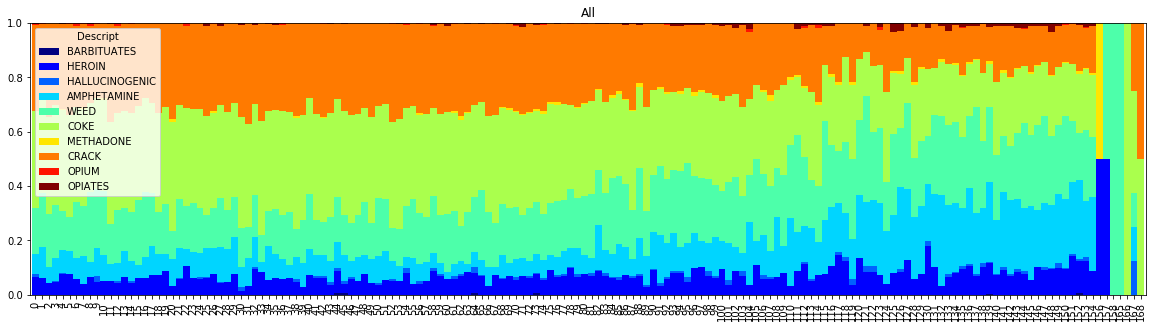

In [47]:
drug_df_all=drug_analysis_rescale(t_all,district,True)

### Focussing on real dates and Districts
#### Let's add the real dates.
#### And focusing on several types of drugs

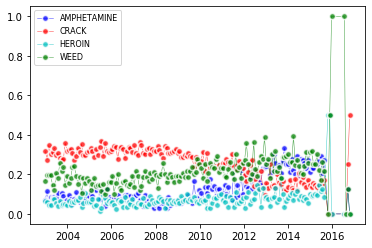

In [48]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['AMPHETAMINE','CRACK','HEROIN','WEED'],['b','r','c','g']):
    plt.plot(dates_for_plot.index,drug_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

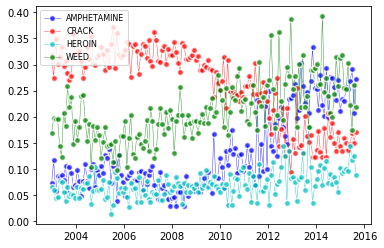

In [49]:
# filter outliers in 2016
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['AMPHETAMINE','CRACK','HEROIN','WEED'],['b','r','c','g']):
    plt.plot(dates_for_plot.head(155).index,drug_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

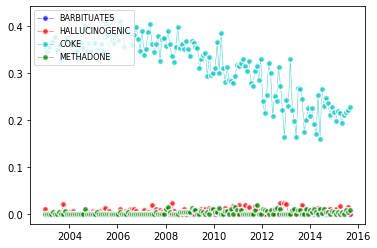

In [50]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['BARBITUATES','HALLUCINOGENIC','COKE','METHADONE'],['b','r','c','g']):
    plt.plot(dates_for_plot.head(155).index,drug_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


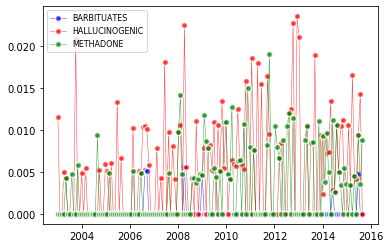

In [51]:
# Eliminate COKe as it has different range
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['BARBITUATES','HALLUCINOGENIC','METHADONE'],['b','r','g']):
    plt.plot(dates_for_plot.head(155).index,drug_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


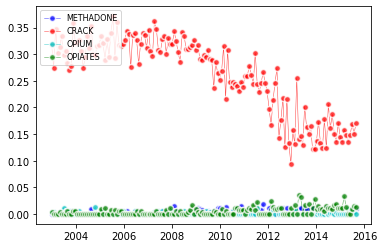

In [52]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['METHADONE','CRACK','OPIUM','OPIATES'],['b','r','c','g']):
    plt.plot(dates_for_plot.head(155).index,drug_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

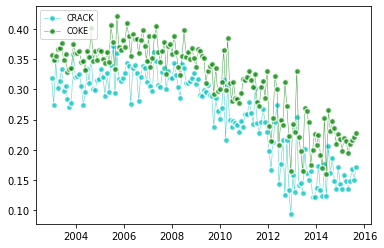

In [53]:
# Examine possible correlation between COKE and CRACK
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['CRACK','COKE'],['c','g']):
    plt.plot(dates_for_plot.head(155).index,drug_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

#### To see more in depth, iterate through each district.

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


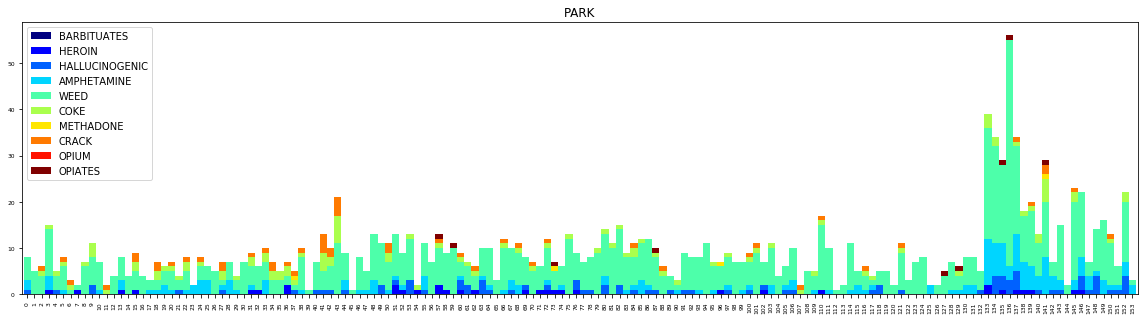

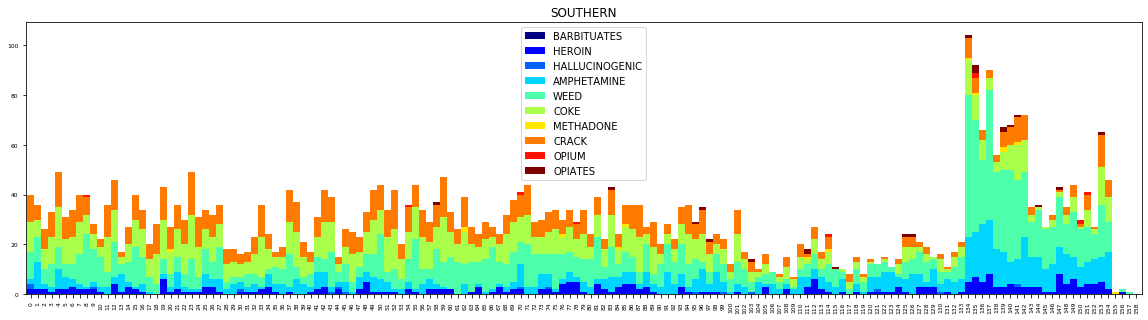

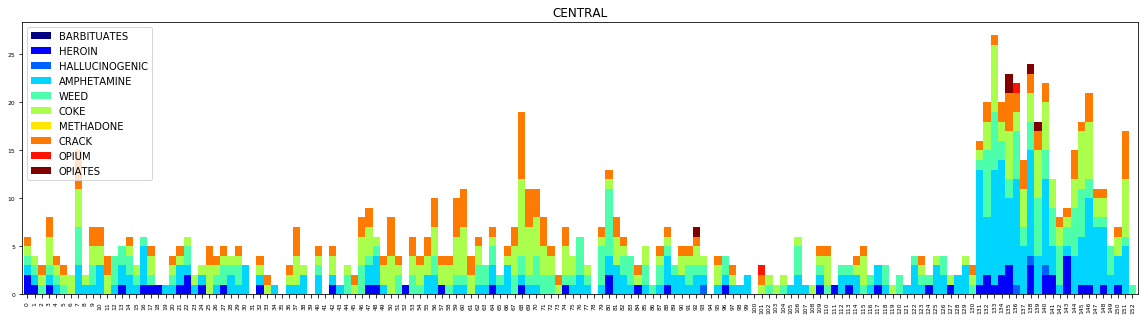

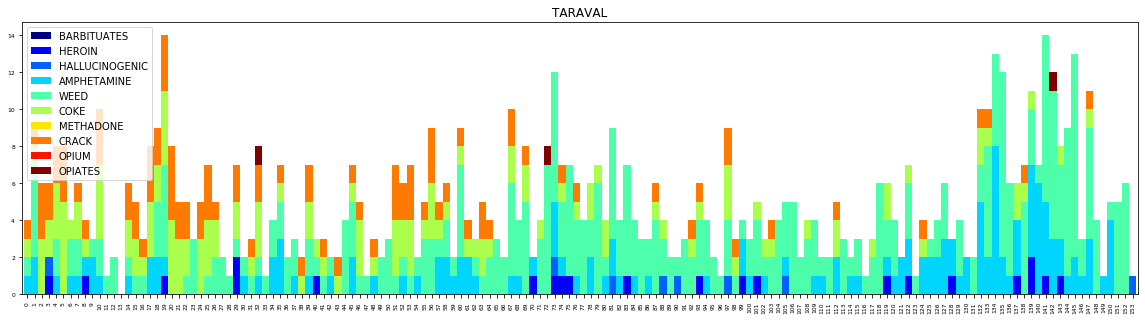

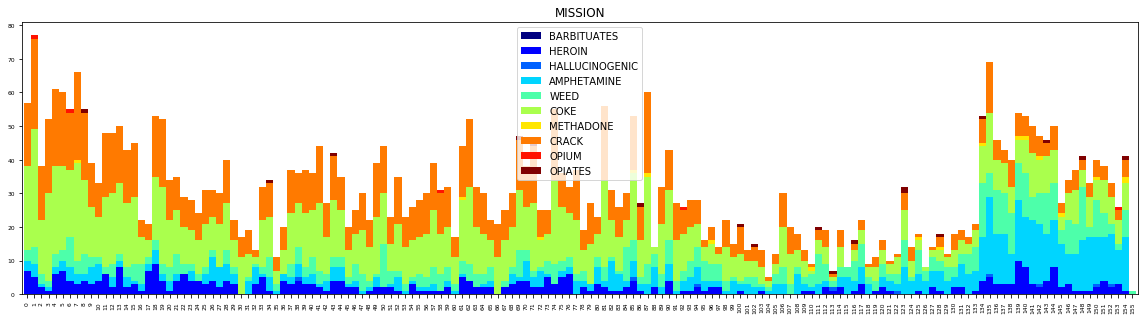

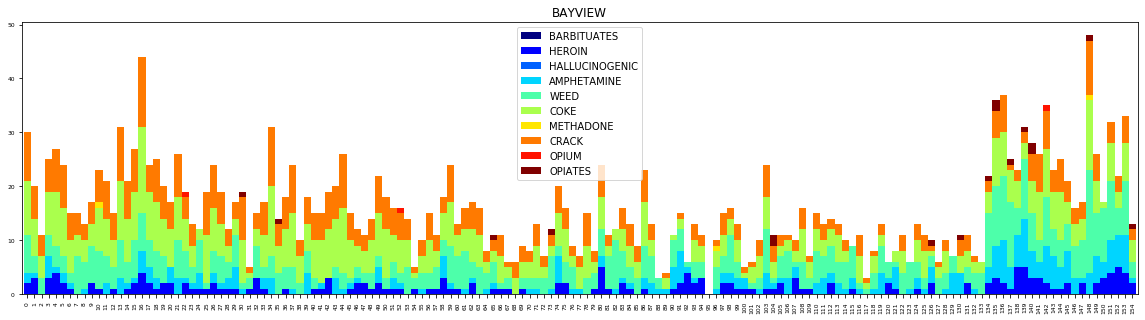

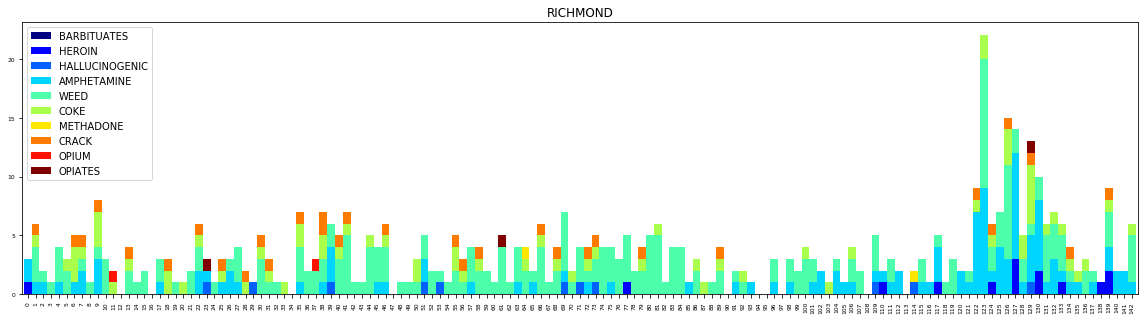

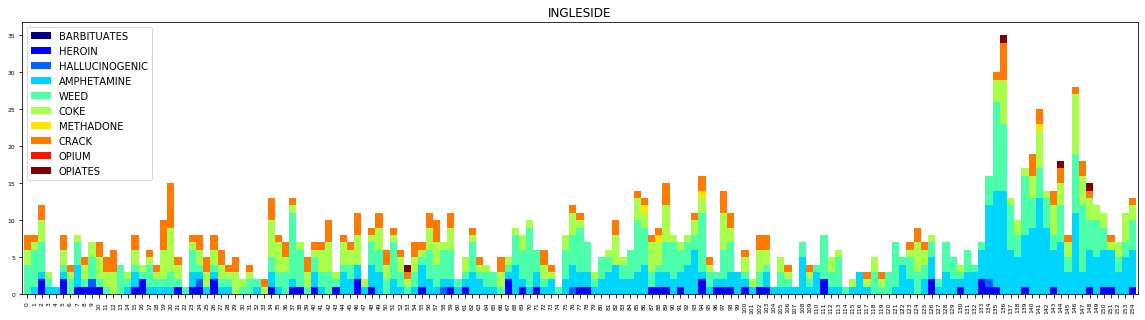

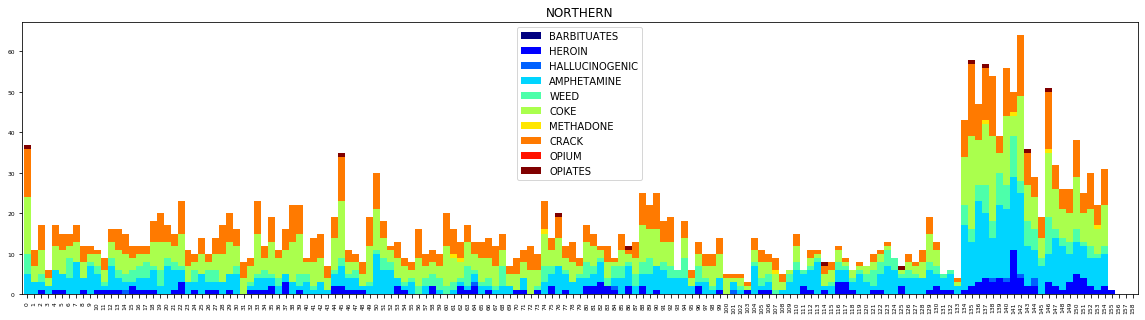

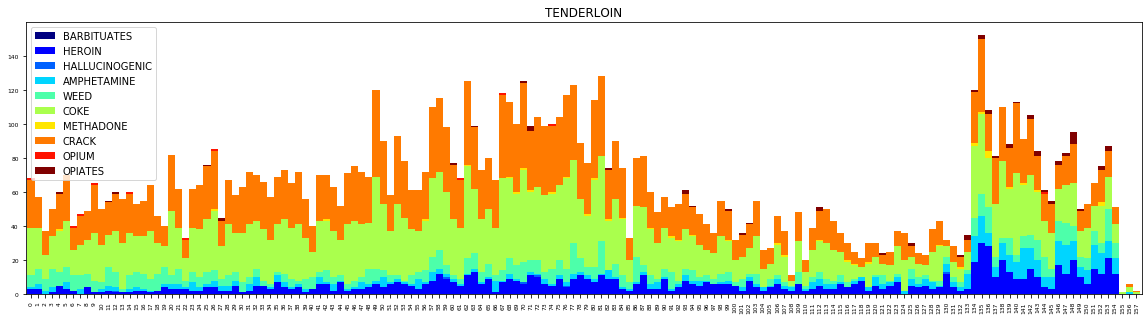

In [54]:
stor=[]
stor_time=[]

for d in set(d_crime['PdDistrict']):
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    drug_df=drug_analysis(m,d,True)
    plt.show()
    s=drug_df.sum(axis=0)
    stor=stor+[s]
    drug_df.columns=cols=[c+"_%s"%d for c in drug_df.columns]
    stor_time=stor_time+[drug_df]
    
drug_dat_time=pd.concat(stor_time,axis=1)
drug_dat=pd.concat(stor,axis=1)
drug_dat.columns=[list(set(d_crime['PdDistrict']))]

### Let's perform Correlation Analysis

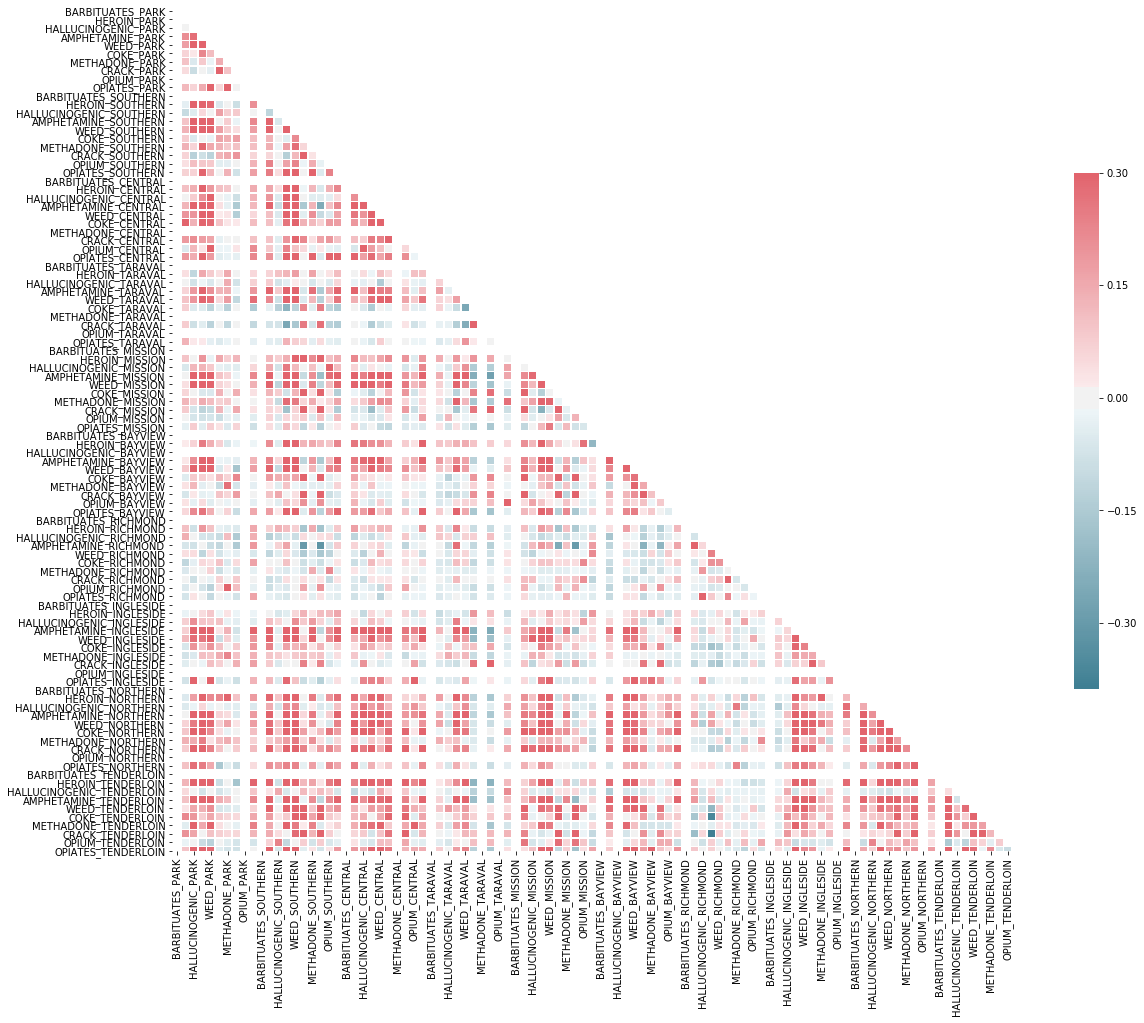

In [55]:
##We can also look at correlations between areas for different drugs.

sns.set_context(rc={"figure.figsize": (20,20)})
corr = drug_dat_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 19))

# Generate a custom diverging colormap
sns.set_context(rc={"figure.figsize": (20,20)})
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(corr,  mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

##### Correlation Analysis

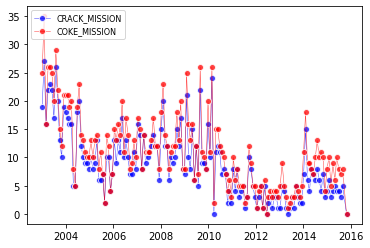

In [56]:
#With this in mind, we can examine select timeseries data.

drug_dat_time.index=dates_for_plot.head(159)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['CRACK_MISSION','COKE_MISSION'],['b','r']):
    plt.plot(drug_dat_time.index,drug_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

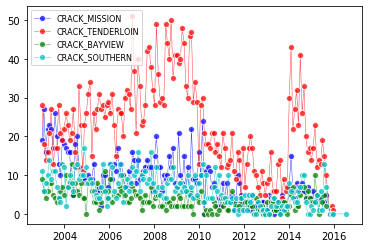

In [57]:
drug_dat_time.index=dates_for_plot.head(159)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['CRACK_MISSION','CRACK_TENDERLOIN','CRACK_BAYVIEW','CRACK_SOUTHERN'],['b','r','g','c']):
    plt.plot(drug_dat_time.index,drug_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

### Now we examine Spatial Relationships

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


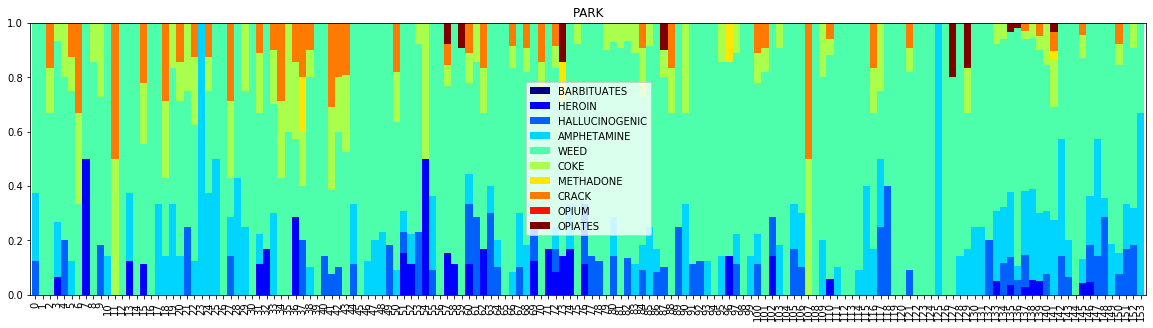

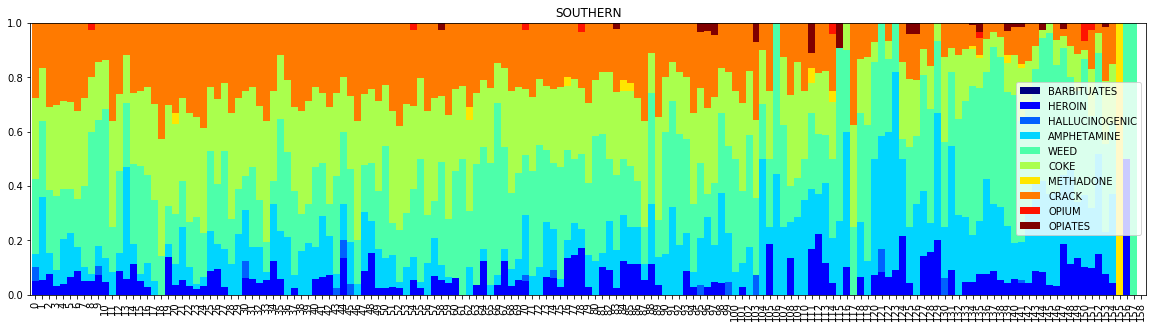

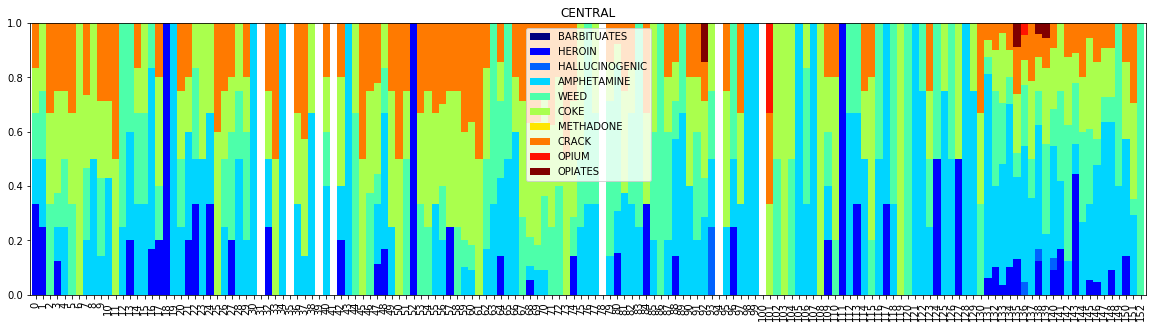

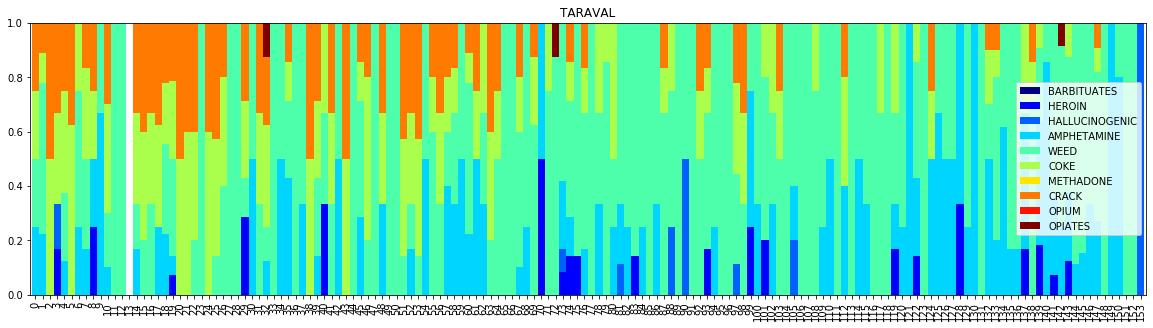

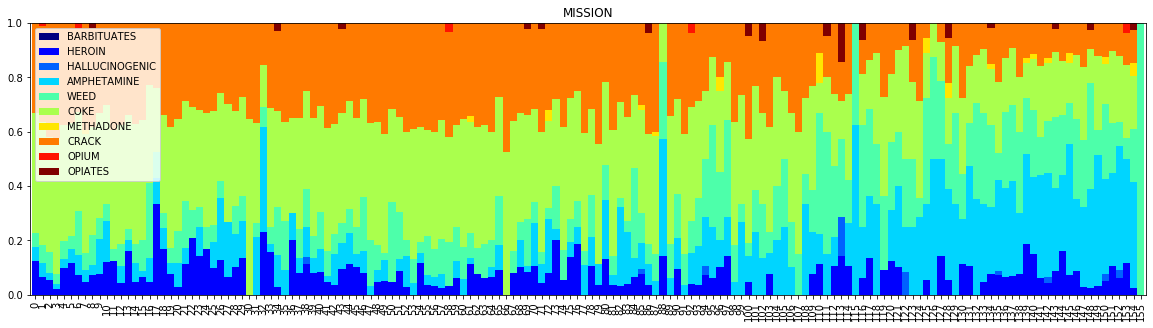

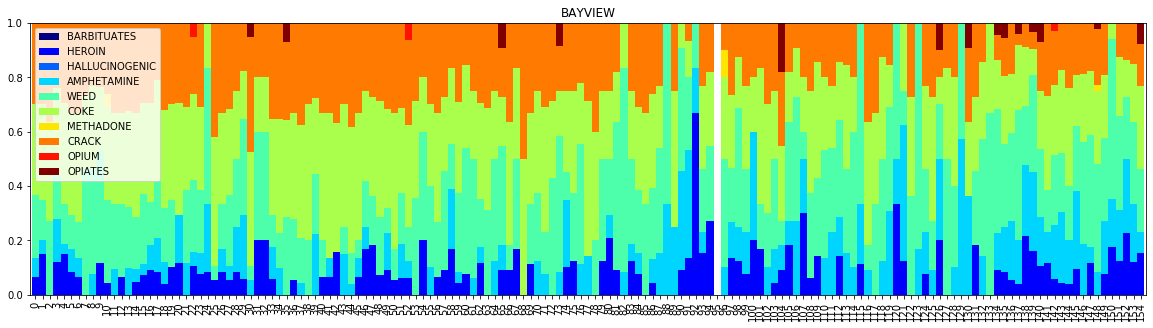

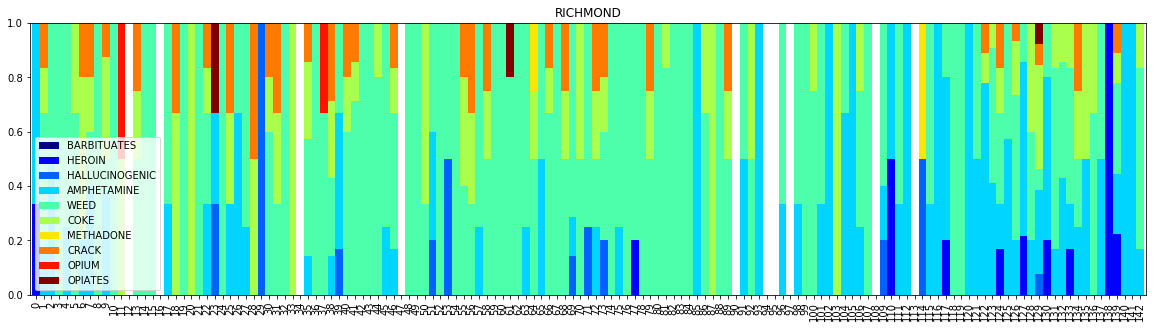

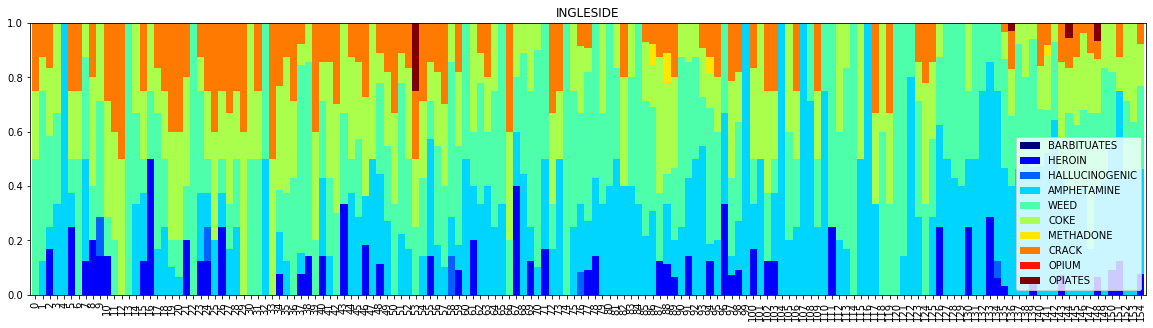

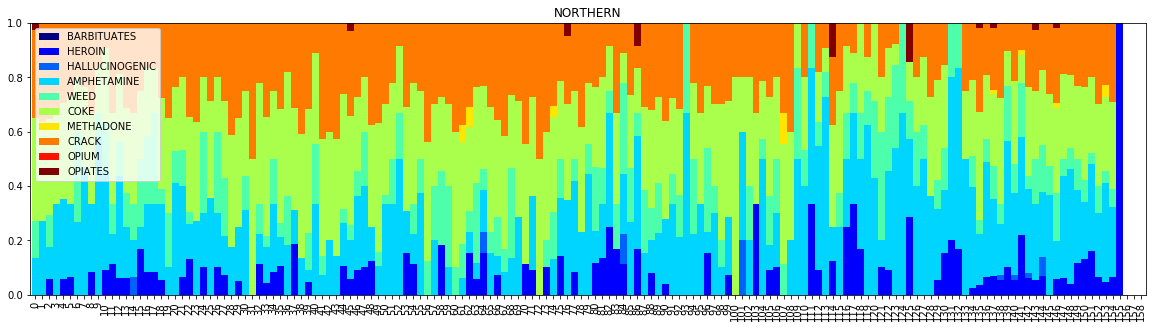

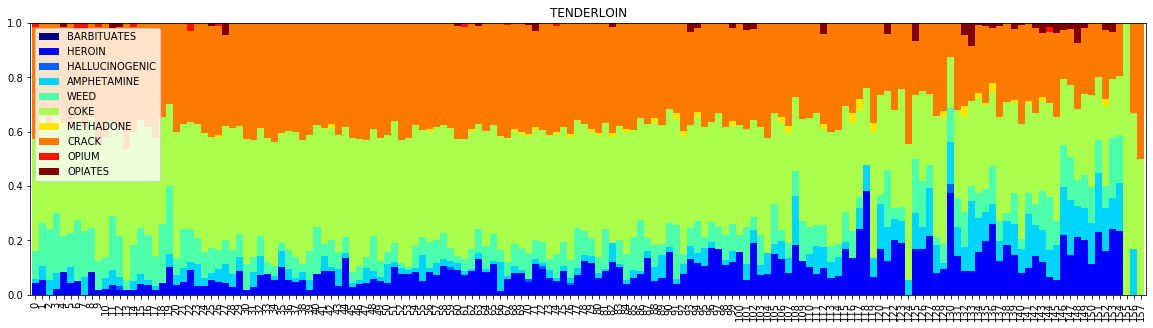

In [58]:
#Let's re-do what we did above, but re-scale it.

stor=[]
stor_time=[]

for d in set(d_crime['PdDistrict']):
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    drug_df=drug_analysis_rescale(m,d,True)
    plt.show()
    s=drug_df.sum(axis=0)
    stor=stor+[s]
    drug_df.columns=cols=[c+"_%s"%d for c in drug_df.columns]
    stor_time=stor_time+[drug_df]
    
drug_dat_time_rescale=pd.concat(stor_time,axis=1)
drug_dat_rescale=pd.concat(stor,axis=1)
drug_dat.columns=[list(set(d_crime['PdDistrict']))]

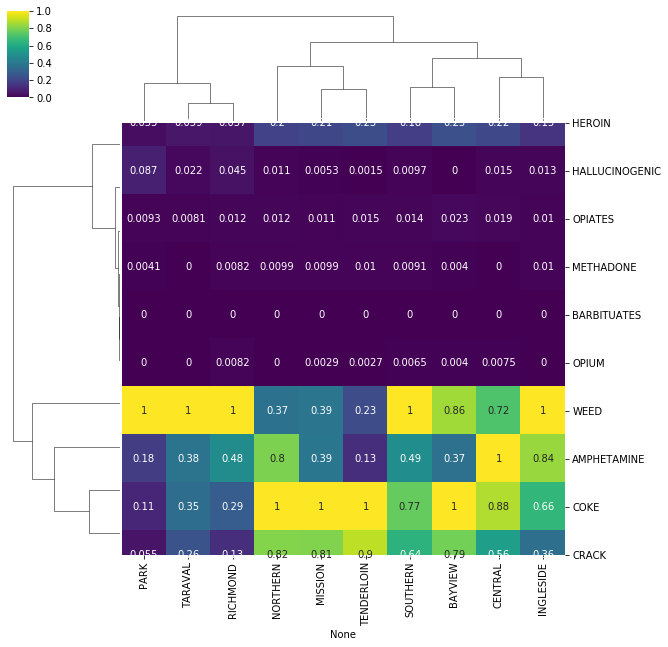

In [59]:
#We can now summarize this data using clustered heatmaps.
sns.clustermap(drug_dat,standard_scale=1,cmap="viridis",robust=True,annot=True)

#### Mapping relationships

In [60]:
#Let's isolate all crack-related records.

tmp=df2.copy()
tmp.set_index('Descript',inplace=True)

crack_dat=tmp.loc[crack_features]
crack_pts=crack_dat[['X','Y','Month']]

In [61]:
#Plot the crack regimes.

d=pd.DataFrame(crack_pts.groupby('Month').size())
d.index=dates_for_plot.head(157)
d.columns=['Count']

diff=len(d.index)-120

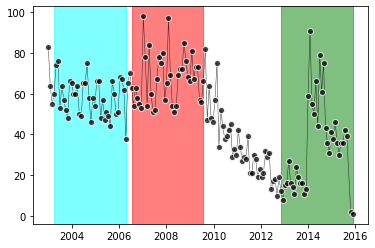

In [62]:
plt.plot(d.index,d['Count'],'o-',color='k',ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.axvspan(d.index[40-diff],d.index[40],color='cyan',alpha=0.5)
plt.axvspan(d.index[80-diff],d.index[80],color='red',alpha=0.5)
plt.axvspan(d.index[120],d.index[-1],color='green',alpha=0.5)

In [63]:
oldest_crack_sums=d.loc[(d.index>d.index[40-diff]) & (d.index<d.index[40])]
old_crack_sums=d.loc[(d.index>d.index[80-diff]) & (d.index<d.index[80])]
new_crack_sums=d.loc[d.index>d.index[120]]

In [64]:
#Fold-difference in mean between the two regimes.
old_crack_sums['Count'].mean()/float(new_crack_sums['Count'].mean())

1.9485116653258243

In [79]:
#Two regimes.

oldest_crack=crack_pts[(crack_pts['Month']>(40-diff)) & (crack_pts['Month']<40)]
oldest_crack.columns=['longitude','latitude','time']
old_crack=crack_pts[(crack_pts['Month']>(80-diff)) & (crack_pts['Month']<80)]
old_crack.columns=['longitude','latitude','time']
new_crack=crack_pts[crack_pts['Month']>120]
new_crack.columns=['longitude','latitude','time']
oldest_crack.head()

longitude   latitude  time
Descript                                                    
POSSESSION OF BASE/ROCK COCAINE -122.419658  37.764221   7.0
POSSESSION OF BASE/ROCK COCAINE -122.392627  37.731618  21.0
POSSESSION OF BASE/ROCK COCAINE -122.412784  37.784866   5.0
POSSESSION OF BASE/ROCK COCAINE -122.437004  37.712934  10.0
POSSESSION OF BASE/ROCK COCAINE -122.419212  37.761024   4.0

### We can look at this spatially.
###### Use a shapefile for Neighborhoods in SF to overlay the data onto a map.
###### https://data.sfgov.org/Geographic-Locations-and-Boundaries/Neighborhoods/ejmn-jyk6
###### Basemap can be used to view this. Some nice work at this link that I drew from:
###### http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html

In [66]:
# Let's create MongoBD collections to manage and query data
col1 = db.cracko
col2 = db.crackn
#Import data into the database
col1.drop()
col2.drop()

In [80]:
new_crack

longitude   latitude   time
Descript                                                     
POSSESSION OF BASE/ROCK COCAINE -122.413174  37.786719  147.0
POSSESSION OF BASE/ROCK COCAINE -122.413404  37.714241  147.0
POSSESSION OF BASE/ROCK COCAINE -122.413757  37.760564  147.0
POSSESSION OF BASE/ROCK COCAINE -122.413791  37.783837  147.0
POSSESSION OF BASE/ROCK COCAINE -122.409854  37.783386  147.0
...                                     ...        ...    ...
SALE OF BASE/ROCK COCAINE       -122.415885  37.783516  130.0
SALE OF BASE/ROCK COCAINE       -122.414406  37.784191  131.0
SALE OF BASE/ROCK COCAINE       -122.419672  37.765050  124.0
SALE OF BASE/ROCK COCAINE       -122.410551  37.782503  130.0
SALE OF BASE/ROCK COCAINE       -122.417904  37.785167  126.0

[1243 rows x 3 columns]

In [67]:
# Collection for new crack
data_json1 = json.loads(new_crack.to_json(orient='records'))
col1.delete_many({})
col1.insert_many(data_json1)

In [68]:
# Collection for old crack
data_json2 = json.loads(old_crack.to_json(orient='records'))
col2.delete_many({})
col2.insert_many(data_json2)

In [69]:
#Check if you can access the data from the MongoDB.
cursor = col1.find().sort('time',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e25966ea22d6df1454f0954'), 'longitude': -122.4107687663, 'latitude': 37.783214519, 'time': 121.0}
{'_id': ObjectId('5e25966ea22d6df1454f0957'), 'longitude': -122.4200809835, 'latitude': 37.7650815377, 'time': 121.0}
{'_id': ObjectId('5e25966ea22d6df1454f0984'), 'longitude': -122.4155082428, 'latitude': 37.7816542806, 'time': 121.0}


In [70]:
cursor2 = col2.find().sort('time',pymongo.ASCENDING).limit(10)
for doc in cursor2:
    print(doc)

{'_id': ObjectId('5e25966ea22d6df1454f0cb5'), 'longitude': -122.4128831779, 'latitude': 37.7853530359, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0cd8'), 'longitude': -122.4133206325, 'latitude': 37.7878471402, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0cf9'), 'longitude': -122.3908661726, 'latitude': 37.7372499016, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0cfe'), 'longitude': -122.3920842307, 'latitude': 37.7373992523, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0d2b'), 'longitude': -122.3937577427, 'latitude': 37.7370014514, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0da1'), 'longitude': -122.4105512818, 'latitude': 37.782502559, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0e2f'), 'longitude': -122.4255868602, 'latitude': 37.7813786258, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0e66'), 'longitude': -122.4098537299, 'latitude': 37.7833862379, 'time': 44.0}
{'_id': ObjectId('5e25966ea22d6df1454f0edb'), 'longitude': -122.4

In [2]:
# Create a new collection to store districts geo points
col3 = db.districts
col3.drop()

NameError: name 'db' is not defined

In [72]:
# mongoBD import from geojson file containing geopoints in form of multipopygons
os.system('"C:\\Program Files\\MongoDB\\Server\\3.4\\bin\\mongoimport" -d test -c districts --file C:\\Users\\Jose-Manuel\\Documents\\DOCENCIA\\MASTER-BD-ADVANCED-ANALYTICS\\2017-2018\\Module5\\Analysis_Neighborhoods.geojson')

32512

In [73]:
cursor3 = col3.find().limit(1)
for doc in cursor3:
    print(doc)

In [74]:
# Get information about the index
col2.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)], 'ns': 'test.crackn'}}

#### Prepare data to perform spatial queries by Mongo

In [75]:
col_temp = db.crackn2
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });

In [76]:
cursor = col_temp.find().limit(10)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e25966ea22d6df1454f1622'), 'loc': {'type': 'Point', 'coordinates': [-122.4170853574, 37.785215359]}}
{'_id': ObjectId('5e25966ea22d6df1454f1623'), 'loc': {'type': 'Point', 'coordinates': [-122.4129705376, 37.7857883767]}}
{'_id': ObjectId('5e25966ea22d6df1454f1624'), 'loc': {'type': 'Point', 'coordinates': [-122.4196583437, 37.7642205604]}}
{'_id': ObjectId('5e25966ea22d6df1454f1625'), 'loc': {'type': 'Point', 'coordinates': [-122.4142178043, 37.7832593295]}}
{'_id': ObjectId('5e25966ea22d6df1454f1626'), 'loc': {'type': 'Point', 'coordinates': [-122.4279850935, 37.7723641437]}}
{'_id': ObjectId('5e25966ea22d6df1454f1627'), 'loc': {'type': 'Point', 'coordinates': [-122.4210578548, 37.7665987781]}}
{'_id': ObjectId('5e25966ea22d6df1454f1628'), 'loc': {'type': 'Point', 'coordinates': [-122.4109552489, 37.784139951]}}
{'_id': ObjectId('5e25966ea22d6df1454f1629'), 'loc': {'type': 'Point', 'coordinates': [-122.4113395626, 37.7812707434]}}
{'_id': ObjectId('5e25966ea22d6df1

In [77]:
cursor2 = col2.find_one()   

In [1]:
# Create index in neiguborhood GeoJson data
col3.create_index({"features.geometry": GEO2D})

NameError: name 'col3' is not defined

In [ ]:
query = {"features.geometry": 
    { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [ ]:
cursor3 = col3.find_one(query)

In [ ]:
# Generate new collection with features filteres
collection_features = db.feat
collection_features.delete_many({})
collection_features.insert_many(cursor3["features"])

In [ ]:
# Obtain cursor
cursor4 = collection_features.find_one()

In [ ]:
# Spatial query implementing getoIntersects operation
query_feat = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [ ]:
# Have a look if every thing is OK
for doc in collection_features.find(query_feat):
    print(doc)

In [ ]:
# Obtain the selected neighborhood
cursor_feat = collection_features.find_one(query_feat)
print(cursor_feat["properties"])

### Printing data in Maps

In [ ]:
# Set general coordinates of San Francisco city
SF_COORDINATES = (37.76, -122.45) ## San Francisco Coordinates

In [ ]:
MAX_RECORDS = 100
m = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [ ]:
#Display neighborhoods by polygons
geo_json_data = json.load(open('C:\\Users\\Jose-Manuel\\Documents\\DOCENCIA\\MASTER-BD-ADVANCED-ANALYTICS\\2017-2018\\Module5\\Analysis_Neighborhoods.geojson'))
folium.GeoJson(geo_json_data).add_to(m)

In [ ]:
# Display Old Crack points (Red)
cursor = col1.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='Old Crack',
                  icon=folium.Icon(color='red')).add_to(m)

In [ ]:
# Display New Crack Points (Green)
cursor = col2.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='New Crack',
                  icon=folium.Icon(color='green')).add_to(m)

In [ ]:
# Display queried point in spatial query (Blue)
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(m)

In [ ]:
folium.LayerControl().add_to(m)

In [ ]:
m.save(outfile='C:\\Users\\Jose-Manuel\\Documents\\DOCENCIA\\MASTER-BD-ADVANCED-ANALYTICS\\2017-2018\\Module5\\map1.html')

In [ ]:
%%HTML
<iframe width="100%" height="350" src="file:///C://Users//Jose-Manuel//Documents//DOCENCIA//MASTER-BD-ADVANCED-ANALYTICS//2017-2018//Module5//map1.html?inline=true"></iframe>

In [ ]:
# Obtaining the geometry of an Incident

In [ ]:
map2 = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [ ]:
folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map2)

In [ ]:
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(map2)

In [ ]:
folium.LayerControl().add_to(map2)

In [ ]:
map2.save(outfile='C:\\Users\\Jose-Manuel\\Documents\\DOCENCIA\\MASTER-BD-ADVANCED-ANALYTICS\\2017-2018\\Module5\\map2.html')

In [ ]:
map2